# 期末專題: 自拍偵測結合透過偵測手部動作自動套用/切換/取消不同種類濾鏡

## 動機
- 取代自拍時需手動設定倒數計時的困擾
- 出門前自拍棒總會忘記充電，在旅程中自拍棒沒電會造成困擾，透過自拍偵測即不須任何操作即可倒數拍照
- 拍照前選擇濾鏡總需動手襙控選擇很久，選完濾鏡後實際套用到臉上可能也不一定合適，又要重新選。此系統實現預先設定幾種自己常用的濾鏡，鏡頭直接面對臉部下可直接透過手部姿勢來更換預設的濾鏡，省去不少困擾
- 可事先設定多種濾鏡，拍照時直接套用，減少了之後一張一張修圖的困擾
- 使用AI makeup技術，免除修圖新手不擅長修圖之困擾
- 可透過特定手勢自動開始/終止自拍

## 實作步驟
1. 尋找selfie dataset並訓練出selfie detection model
2. 尋找hand sign dataset並訓練出hand sign detection model
3. 使用opencv抓取鏡頭內照片
4. 使用cvzone之PostDetector抓取身體物件
5. 透過身體物件之數據計算出身體物件佔畫面之比例(在此稱body_rate)
6. 使用MTCNN的進行臉部偵測抓取臉部
7. 偵測到臉部以及body_rate符合則進行selfie detect，符合則倒數自拍
8. 使用cvzone之HandDetector抓取手部物件
9. 在倒數階段，若手筆出特定數字之手勢，則可切換至該mode之濾鏡
10. 修改現成之AIMakeUp程式，透過實現臉部濾鏡套入MTCNN擷取出的臉部

參考之AIMakeUp gitHub: https://github.com/QuantumLiu/AIMakeup

## 操作概念
1. 使用者面向鏡頭，偵測到自拍動作後，自動倒數計時10秒，亦可透過手部動作控制倒數計時開始終止
2. 使用者在同時被抓捕到臉部以及手時，會配對最近距離之臉部手部視為同個人，偵測手部動作對該臉部套用對應手勢之濾鏡
3. 使用者可事先設定好數個客製化濾鏡


## 引入套件

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import random
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

try:
    import mtcnn
except:
    !pip install mtcnn    
    import mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 3.5 MB/s 


In [ ]:
# Download kaggle data in Google Colab
! pip install -q kaggle
from google.colab import files
if(not os.path.exists('./kaggle.json')):
  files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Selfie Detection

## 資料預處理

### 下載Selfie-Image-Detection-Dataset

In [ ]:
if(not os.path.exists('./selfie-detection')):
  # Create a folder to store the dataset
  ! mkdir selfie-detection
  # Download the selfieimagedetectiondataset dataset
  ! kaggle datasets download -d jigrubhatt/selfieimagedetectiondataset

100% 2.81G/2.81G [00:48<00:00, 114MB/s] 
100% 2.81G/2.81G [00:48<00:00, 62.1MB/s]


In [ ]:
# Unzip it and store it to the 'selfie-detection' folder
! unzip selfieimagedetectiondataset.zip -d selfie-detection

串流輸出內容已截斷至最後 5000 行。
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26784.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26785.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26786.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26787.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26788.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26789.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26790.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26791.jpg  
  inflating: selfie-detection/Selfie-Image-Detection-Dataset/Validation_data/NonSelfie/NonSelfie26792.jpg  
  infla

### 建立訓練，驗證，測試資料集

In [ ]:
# process training data
train_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Training_data')
train_filepaths = pd.Series(list(train_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
train_selfie = pd.Series(train_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(train_selfie)):
  if train_selfie[i] == 'Selfie':
    train_selfie[i] = 1
  else:
    train_selfie[i] = 0
train_selfie = train_selfie.astype(np.int32)

train_images = pd.concat([train_filepaths, train_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

# process training data
val_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Validation_data')
val_filepaths = pd.Series(list(val_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
val_selfie = pd.Series(val_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(val_selfie)):
  if val_selfie[i] == 'Selfie':
    val_selfie[i] = 1
  else:
    val_selfie[i] = 0
val_selfie = val_selfie.astype(np.int32)

val_images = pd.concat([val_filepaths, val_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

# process testing data
test_image_dir = Path('./selfie-detection/Selfie-Image-Detection-Dataset/Test_data')

test_filepaths = pd.Series(list(test_image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
test_selfie = pd.Series(test_filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='action').astype(str)
for i in range(len(test_selfie)):
  if test_selfie[i] == 'Selfie':
    test_selfie[i] = 1
  else:
    test_selfie[i] = 0
test_selfie = test_selfie.astype(np.int32)

test_images = pd.concat([test_filepaths, test_selfie], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
train_images

,Filepath,action
0,selfie-detection/Selfie-Image-Detection-Datase...,0
1,selfie-detection/Selfie-Image-Detection-Datase...,1
2,selfie-detection/Selfie-Image-Detection-Datase...,1
3,selfie-detection/Selfie-Image-Detection-Datase...,0
4,selfie-detection/Selfie-Image-Detection-Datase...,0
...,...,...
62890,selfie-detection/Selfie-Image-Detection-Datase...,1
62891,selfie-detection/Selfie-Image-Detection-Datase...,0
62892,selfie-detection/Selfie-Image-Detection-Datase...,0
62893,selfie-detection/Selfie-Image-Detection-Datase...,1


### 在train_images中取20000個當作訓練資料來加快訓練速度，在validation_images中取6000個當作驗證資料，在test_images中取6000個當作測試資料




In [ ]:
# get specific amount of data
train_df = train_images.sample(20000, random_state=1).reset_index(drop=True)
val_df = val_images.sample(6000, random_state=1).reset_index(drop=True)
test_df = test_images.sample(6000, random_state=1).reset_index(drop=True)

In [ ]:
train_df

,Filepath,action
0,selfie-detection/Selfie-Image-Detection-Datase...,1
1,selfie-detection/Selfie-Image-Detection-Datase...,1
2,selfie-detection/Selfie-Image-Detection-Datase...,0
3,selfie-detection/Selfie-Image-Detection-Datase...,0
4,selfie-detection/Selfie-Image-Detection-Datase...,1
...,...,...
11995,selfie-detection/Selfie-Image-Detection-Datase...,0
11996,selfie-detection/Selfie-Image-Detection-Datase...,0
11997,selfie-detection/Selfie-Image-Detection-Datase...,1
11998,selfie-detection/Selfie-Image-Detection-Datase...,1


### 數據規格化

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

val_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

### 獲得DataFrameIterator

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath', 
    y_col='action', 
    target_size=(150, 150), 
    color_mode='rgb', 
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='action',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='action',
    target_size=(150, 150),
    color_mode='rgb',
    class_mode='raw',
    batch_size=32,
    shuffle=False
)


Found 12000 validated image filenames.
Found 3000 validated image filenames.
Found 3000 validated image filenames.


## 建立模型

### 定義模型之函式
#### train_model()
- 使用Adam作為優化函式
- 使用MSE做loss function
- 訓練時加入callback function: 加入early stopping防止過擬合

#### plot_history()
- 將loss，val_loss，epoch繪製圖表

#### evaluate_model()
- 使用RMSE和R-squared評估模型

In [ ]:
# model training, plotting and evaluating
def train_model(model):
    # init and compile the model 
    opt = tf.keras.optimizers.Adam(learning_rate = 0.0001, decay=1e-6)
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
    # train
    history = model.fit(train_images, validation_data=val_images, epochs=100, callbacks=[
            tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)
          ]
    )
    plot_history(history)
    evaluate_model(model)

# plotting the loss-epoch function
def plot_history(history):
    fig, axs = plt.subplots(2)
    fig.tight_layout()
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title("loss")
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title("accuracy")
    plt.xlabel('epoch')
    plt.show()
    
# model evaluation with RMSE and R^2 scores
def evaluate_model(model):
    predicted_action = np.squeeze(model.predict(test_images))
    true_action = test_images.labels

    r2 = r2_score(true_action, predicted_action)
    print("Test R^2 Score: {:.5f}".format(r2))

### CNN模型
- 使用CNN
- Activation Layer使用relu函數，去掉負值
- Pooling Layer使用Max Pooling，保留重要資訊，對圖片抗雜訊
- 使用Dropout Layer斷開輸入神經元，用於防止過度擬合，斷開比例:0.2

In [ ]:
my_model = tf.keras.Sequential([
    layers.InputLayer(input_shape=[150,150,3]),
    
    #Block One
    layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Two
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    
    #Block Three
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),

    #Block Four
    layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Block Five
    layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(),
    layers.Dropout(0.2),
    
    #Head
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
    
])

### 訓練模型

In [ ]:
train_model(my_model)

Epoch 1/100
375/375 [==============================] - 2413s 6s/step - loss: 0.1467 - accuracy: 0.8369 - val_loss: 0.2280 - val_accuracy: 0.6633
Epoch 2/100
375/375 [==============================] - 2377s 6s/step - loss: 0.0842 - accuracy: 0.9007 - val_loss: 0.1069 - val_accuracy: 0.8873
Epoch 3/100
274/375 [====================>.........] - ETA: 10:06 - loss: 0.0715 - accuracy: 0.9153

KeyboardInterrupt: ignored

### 儲存模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
my_model.save('./my_model.h5')

In [ ]:
my_model.save('./drive/MyDrive/machine-learning/Selfie-Detection/my_model.h5')

### 載入模型

In [ ]:
reload_model = tf.keras.models.load_model('./my_model.h5')

### 自拍預測

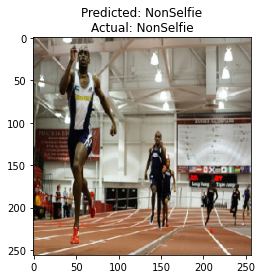

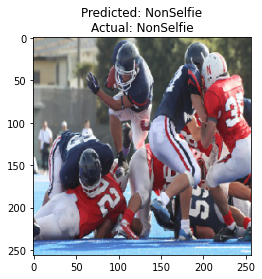

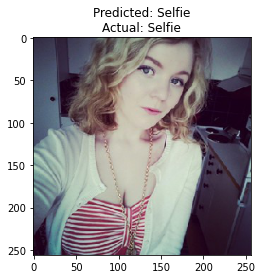

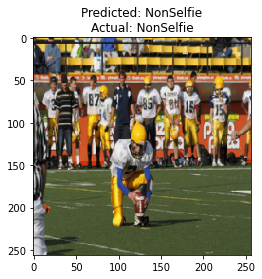

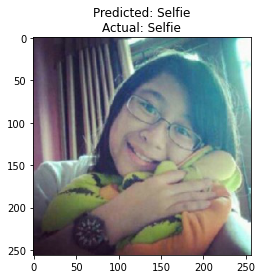

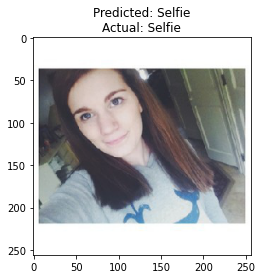

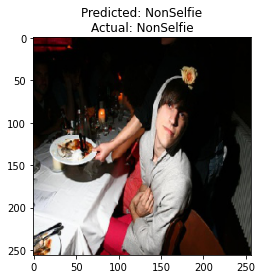

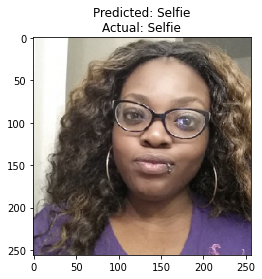

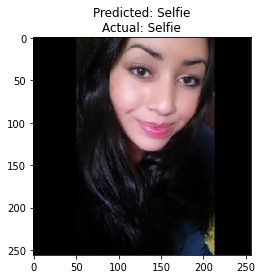

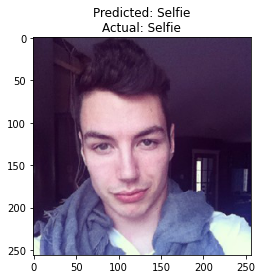

In [ ]:
for i in range(10):
  number = random.randint(0, 6000)
  row = test_df.loc[number]
  filepath = row['Filepath']
  action = row['action']
  image = tf.keras.preprocessing.image.load_img(filepath, target_size=(256,256))
  input_arr = np.array([tf.keras.preprocessing.image.img_to_array(image)]).astype('float32') / 255
  predictions = my_model.predict(input_arr)
  predicted_action = ''
  if(predictions[0][0]>0.5):
    predicted_action='Selfie'
  else:
    predicted_action='NonSelfie'

  plt.figure()
  plt.imshow(image)

  #actual_age = images['Age'][images[images['Filepath'] == test_image].index.values[0]].astype(str)
  if(action==1):
    action='Selfie'
  else:
    action='NonSelfie'
  actual_action = action

  plt.title('Predicted: ' + predicted_action + '\n' +
          'Actual: ' + actual_action)

  plt.show()

# Hand Sign Detector

## 引入套件

In [ ]:
import numpy as np
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D
from keras.models import Sequential, save_model
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import cv2
import keras.backend as K

## 資料預處理

### 下載sign-language-gesture-images-dataset

In [ ]:
if(not os.path.exists('./hand-sign-detection')):
  # Create a folder to store the dataset
  ! mkdir hand-sign-detection
  # Download the dataset
  #! kaggle datasets download -d ahmedkhanak1995/sign-language-gesture-images-dataset
  ! kaggle datasets download -d muhammadkhalid/sign-language-for-numbers

100% 48.0M/48.1M [00:00<00:00, 127MB/s]
100% 48.1M/48.1M [00:00<00:00, 119MB/s]


In [ ]:
# Unzip it and store it to the 'hand-sign-detection' folder
#! unzip sign-language-gesture-images-dataset.zip -d hand-sign-detection
! unzip sign-language-for-numbers.zip -d hand-sign-detection

串流輸出內容已截斷至最後 5000 行。
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_549.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_55.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_550.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_551.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_552.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_553.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_554.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_555.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_556.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_557.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_558.jpg  
  inflating: hand-sign-detection/Sign Language for Numbers/7/seven_559.jpg  
  inflating: hand-sign-detection/Sign Language for Numbe

### 刪除不必要資料

In [ ]:
import string
import shutil
from sklearn.utils import shuffle

# process training data
path = './hand-sign-detection/Sign Language for Numbers/'

unnecessary = ['6', '7', '8']

for folder in unnecessary:
  if(os.path.exists(path+folder)):
    shutil.rmtree(path+folder)


"""
alphabets = list(string.ascii_uppercase)

if(os.path.exists(path+'_')):
  shutil.rmtree(path+'_')

  for alphabet in alphabets:
    if(os.path.exists(path+alphabet)):
      shutil.rmtree(path+alphabet)
"""
gestures = os.listdir(path)


### 建立一個label dictionary

In [ ]:
dict_labels = {
    '0':0,
    '1':1,
    '2':2,
    '3':3,
    '4':4,
    '5':5,
    '9':9, 
    'unknown':10
}
print(list(dict_labels.keys()))

['0', '1', '2', '3', '4', '5', '9', 'unknown']


### 建立訓練，測試資料

In [ ]:
x, y = [], []
for ix in gestures:
    images = os.listdir(path + ix)
    for cx in images:
        img_path = path + ix + '/' + cx
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
        img = img.reshape((50,50,1))
        img = img/255.0
        x.append(img)
        y.append(dict_labels[ix])

In [ ]:
X = np.array(x)
Y = np.array(y)
Y = np_utils.to_categorical(Y)
X, Y = shuffle(X, Y, random_state=0)
categories = Y.shape[1]

In [ ]:
print(X.shape)
print(Y.shape)

(12000, 50, 50, 1)
(12000, 11)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

## 建立，訓練，評估模型

### 建立模型

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=(50,50 ,1) ))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.20))
model.add(Dense(categories, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

### 定義模型之函式

In [ ]:
# model training, plotting and evaluating
def train_model(model):
    # init and compile the model 
    model.compile(optimizer='Adam', metrics=['accuracy'], loss='categorical_crossentropy')
    # train
    history = model.fit(X_train, Y_train, batch_size=150, epochs=50, validation_data=[X_test, Y_test], callbacks=[
            tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=5, restore_best_weights=True)
          ]
    )
    plot_history(history)
    evaluate_model(model)

# plotting the loss-epoch function
def plot_history(history):
    fig, axs = plt.subplots(2)
    fig.tight_layout()
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title("loss")
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title("accuracy")
    plt.xlabel('epoch')
    plt.show()

# model evaluation with RMSE and R^2 scores
def evaluate_model(model):
    predicted_action = np.squeeze(model.predict(X_test))
    true_action = Y_test

    r2 = r2_score(true_action, predicted_action)
    print("Test R^2 Score: {:.5f}".format(r2))

### 訓練模型

Epoch 1/50
60/60 [==============================] - 13s 27ms/step - loss: 2.1059 - accuracy: 0.1647 - val_loss: 1.8611 - val_accuracy: 0.3417
Epoch 2/50
60/60 [==============================] - 1s 20ms/step - loss: 1.4541 - accuracy: 0.4792 - val_loss: 1.0488 - val_accuracy: 0.6773
Epoch 3/50
60/60 [==============================] - 1s 20ms/step - loss: 0.8844 - accuracy: 0.7108 - val_loss: 0.6963 - val_accuracy: 0.7700
Epoch 4/50
60/60 [==============================] - 1s 21ms/step - loss: 0.6088 - accuracy: 0.8028 - val_loss: 0.5311 - val_accuracy: 0.8200
Epoch 5/50
60/60 [==============================] - 1s 20ms/step - loss: 0.4756 - accuracy: 0.8429 - val_loss: 0.4171 - val_accuracy: 0.8730
Epoch 6/50
60/60 [==============================] - 1s 20ms/step - loss: 0.3695 - accuracy: 0.8779 - val_loss: 0.3477 - val_accuracy: 0.8850
Epoch 7/50
60/60 [==============================] - 1s 20ms/step - loss: 0.3001 - accuracy: 0.9039 - val_loss: 0.3026 - val_accuracy: 0.8983
Epoch 8/50
6

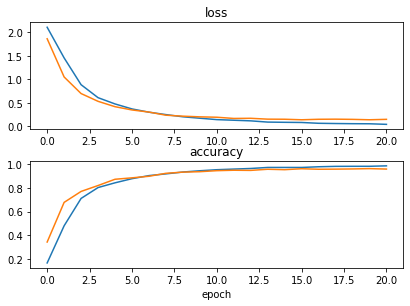

Test R^2 Score: 0.67679


In [ ]:
train_model(model)

### 準確度

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_pred.round())*100

95.56666666666666

## 儲存模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('hand_model.h5')

In [ ]:
model.save('./drive/MyDrive/machine-learning/Selfie-Detection/hand_model.h5')

In [ ]:
hand_model = tf.keras.models.load_model('./drive/MyDrive/machine-learning/Selfie-Detection/hand_model.h5')

## 預測

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
tf.Tensor(2, shape=(), dtype=int64)


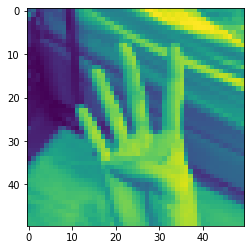

In [ ]:
dict_labels = {
    '0':0,
    '1':1,
    '2':2,
    '3':3,
    '4':4,
    '5':5,
    '9':9 
}
x, y = [], []
img_path = './4.jpg'

img = cv2.imread(img_path, 0)
img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
plt.figure()
plt.imshow(img)
img = img.reshape((50,50,1))
img = img/255.0
x.append(img)
X = np.array(x)


Y_pred = hand_model.predict(X)
print(Y_pred.round())
predict = K.argmax(Y_pred,axis=-1)
print(predict[0])